# MLBD : Project on the music dataset

The base subject is : Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party). By playlist we mean a set of songs that can be from the same artist or multiple ones.

Research questions : 
- How do we compute the metrics for similarity between user ?
- What is the impact of the number of plays ?
- What is the impact of the gender, age and country on the kind of music people are listening to ?
- Not a question : Use the Spotify API to access to the genre, maybe. (using Spotipy)
- See what we can get from the Spotify API !
- Can we generate a music playlist for multiple users based on what they listened?

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import credentials
import ast
import os

In [3]:
sp = spotipy.Spotify(auth_manager = SpotifyClientCredentials(client_id = credentials.clientId, client_secret = credentials.clientSecret))

### 2. Load the data

In [4]:
DATA_FOLDER = 'data/'
TOP_FOLDER = DATA_FOLDER + 'lastfm-dataset-360k/'
TIMELINE_FOLDER = DATA_FOLDER + 'lastfm-dataset-1k/'

top_user = pd.read_csv(TOP_FOLDER + 'usersha1-profile.tsv', sep = '\t', error_bad_lines = False, header = None)
top_data = pd.read_csv(TOP_FOLDER + 'usersha1-artmbid-artname-plays.tsv', sep = '\t', error_bad_lines = False, header = None)

timeline_user = pd.read_csv(TIMELINE_FOLDER + 'userid-profile.tsv', sep = '\t', error_bad_lines = False, header = 0)
timeline_data = pd.read_csv(TIMELINE_FOLDER + 'userid-timestamp-artid-artname-traid-traname.tsv', sep = '\t', error_bad_lines = False, header = None)

# This file was created using the data expansion done in part 4
add_data = pd.read_csv(DATA_FOLDER + 'full_spotify_info.csv', error_bad_lines = False, header = 0)

top_user.rename(columns = {0 : 'ID', 1 : 'Gender', 2 : 'Age', 3 : 'Country', 4 : 'Registered'}, inplace = True)
top_data.rename(columns = {0 : 'ID', 1 : 'Artist_ID', 2 : 'Artist', 3 : 'Plays'}, inplace = True)
timeline_user.rename(columns = {'#id' : 'ID', 'gender' : 'Gender', 'age' : 'Age', 'country' : 'Country', 'registered' : 'Registered'}, inplace = True)
timeline_data.rename(columns = {0 : 'ID', 1 : 'Timestamp', 2 : 'Artist_ID', 3 : 'Artist', 4 : 'Track_ID', 5 : 'Track'}, inplace = True)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


In [8]:
top_merged = top_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID', 'Registered'])
top_merged = top_merged.drop(top_merged[top_merged.isna().any(axis = 1)].index)

In [9]:
# We decide to eliminate users, which have less than 6 favourite artists (as per Aleandro's advice)
top_merged_IDs = top_merged.groupby(['ID']).size().reset_index()
users_id = top_merged_IDs[top_merged_IDs[0] > 5]['ID']
top_merged = top_merged[top_merged['ID'].isin(users_id)]

In [10]:
# we have almost 300k artists
top_plays = top_merged.groupby(['Artist']).size().sort_values(ascending = True).reset_index(name = 'Sum of plays')
# we check how many times an artist occurs in dataset
top_plays

,Artist,Sum of plays
0,04)],1
1,john mcdonough,1
2,john mcdaniel iii,1
3,john mcbain,1
4,john mcarthur,1
...,...,...
249789,muse,37313
249790,red hot chili peppers,38358
249791,coldplay,50624
249792,the beatles,57372


In [11]:
# to reduce the dataset, we'll drop artists who were listened only by less than x users
top_artists = top_plays[top_plays['Sum of plays'] > 1000]['Artist']
top_merged = top_merged.loc[top_merged['Artist'].isin(top_artists)].reset_index().drop(columns = ['index'])

# If all of as agree, we can play with artists below for now

In [12]:
top_artists

247646              los piratas
247647     charlotte gainsbourg
247648             edvard grieg
247649          the wallflowers
247650                    milow
                  ...          
249789                     muse
249790    red hot chili peppers
249791                 coldplay
249792              the beatles
249793                radiohead
Name: Artist, Length: 2148, dtype: object

### 4. Data expansion

We will use the Spotify API to fetch some additional informations about the artists. We chose to limit ourselves to the artist which have more than 20 users listening to them and a minimum of 50 plays per user.

This part does not need to be run again.

In [34]:
import time
def spotipySearch(x) :
    s = sp.search(q = 'artist:' + str(x), type = 'artist')
    inter = s['artists']['items']
    if(len(inter) > 0) :
        inter[0]
        time.sleep(1) 
    else :
        return []
        time.sleep(1) 

In [14]:
nbUser = top_data.groupby(by = 'Artist').size()
multipleUsers = nbUser[nbUser > 20].reset_index()[['Artist']]
mostListened = top_data[top_data['Plays'] > 50][['Artist']]
filteredArtist = multipleUsers.merge(mostListened, on = 'Artist')['Artist'].unique()
filteredArtist.size

44623

In [15]:
top_data_genre = pd.DataFrame(data = {'Artist' : filteredArtist})
top_data_genre.head()

,Artist
0,los piratas
1,charlotte gainsbourg
2,edvard grieg
3,the wallflowers
4,milow
...,...
2143,muse
2144,red hot chili peppers
2145,coldplay
2146,the beatles


In [35]:
top_data_genre['Info'] = top_data_genre.Artist.apply(lambda x: spotipySearch(x))
top_data_genre.head()

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

In [ ]:
top_data_genre.to_csv(DATA_FOLDER + 'full_spotify_correct_info.csv', index = False)

### 5. Spotify API data analysis

We first need to change the Info column from a string to a dictionary

In [18]:
add_data['Info'] = add_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
add_data.head()

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...


In [19]:
add_data['Genres'] = add_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
add_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [20]:
genres = add_data['Genres'].tolist()
all_genres = [item for sublist in genres for item in sublist]
unique_genres = set(all_genres)
len(unique_genres)

4258

In [21]:
from collections import Counter
c = Counter(all_genres)
c.most_common(25)

[('rock', 665),
 ('dance pop', 511),
 ('hip hop', 475),
 ('country rock', 460),
 ('pop rock', 454),
 ('pop', 449),
 ('rap', 415),
 ('mellow gold', 412),
 ('adult standards', 402),
 ('classic rock', 395),
 ('alternative metal', 391),
 ('alternative rock', 387),
 ('soft rock', 387),
 ('folk rock', 381),
 ('pop rap', 366),
 ('indie rock', 362),
 ('album rock', 362),
 ('art rock', 358),
 ('new wave pop', 357),
 ('folk', 356),
 ('urban contemporary', 350),
 ('hard rock', 349),
 ('latin', 346),
 ('funk', 345),
 ('post-teen pop', 334)]

In [22]:
def best_genre(l, c) :
    best = ""
    best_num = 0
    for elem in l:
        if(c[elem] > best_num) :
            best = elem
            best_num = c[elem]
    return best

In [23]:
add_data['best_genre'] = add_data['Genres'].map(lambda x: best_genre(x, c))
add_data.head()

,Artist,Info,Genres,best_genre
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el...",electronica
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]",uk82
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]",balkan brass
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]",neo-synthpop
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore],technical grindcore


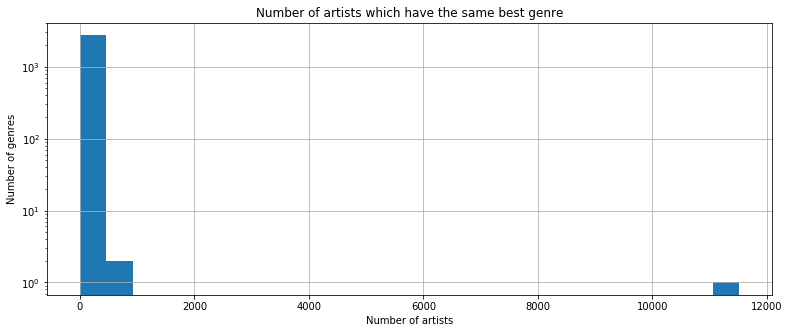

In [24]:
add_data.groupby('best_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same best genre')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [25]:
add_data.groupby('best_genre').size()

best_genre
                    11522
a cappella             20
abstract                4
abstract beats          3
abstract hip hop       42
                    ...  
zim urban groove        1
zither                  1
zolo                   15
zouk                   13
zydeco                  1
Length: 2732, dtype: int64

In this case, we see that there are 11522 artists which do not have any genres attached to them, this probably comes from a lack of information about these artists in general from Spotify.

In [26]:
add_data = add_data[add_data['Genres'].map(len) > 0]

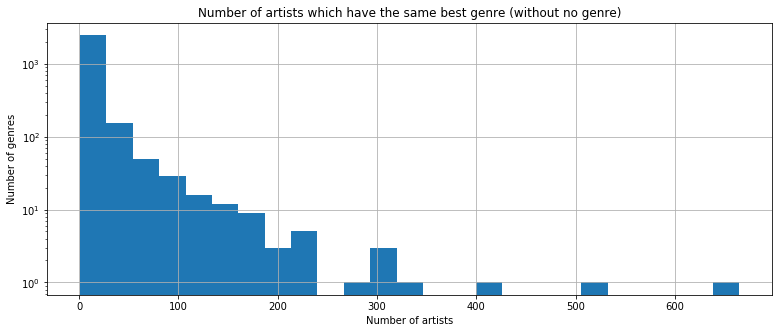

In [27]:
add_data.groupby('best_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same best genre (without no genre)')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [28]:
add_data['Popularity'] = add_data['Info'].apply(lambda x: x['followers']['total'])

/Users/rap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


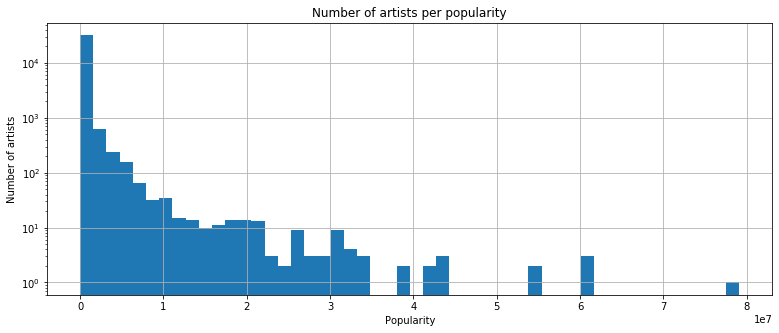

In [29]:
add_data['Popularity'].hist(bins = 50, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists per popularity')
plt.xlabel('Popularity')
_ = plt.ylabel('Number of artists')

In [30]:
add_data.set_index('Artist')['Popularity'].sort_values()

Artist
canto finlandia           1
비                         2
fatima                    2
david wright              2
manian                    2
                     ...   
drake              54510167
ari                61638703
aria               61638703
arian              61638703
she                79118817
Name: Popularity, Length: 33101, dtype: int64

In [31]:
add_data['Info'][34368]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6eUKZXaKkcviH0Ku9w2n3V'},
 'followers': {'href': None, 'total': 79118817},
 'genres': ['pop', 'uk pop'],
 'href': 'https://api.spotify.com/v1/artists/6eUKZXaKkcviH0Ku9w2n3V',
 'id': '6eUKZXaKkcviH0Ku9w2n3V',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/c9e693f336bc004af00c51bbf0a157e8b5af75f2',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ebe13258cf525b7399ea1b34a25d38172b3023a1',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/05fc0a0a6b74757e87da8081c358f5ee972466db',
   'width': 160}],
 'name': 'Ed Sheeran',
 'popularity': 92,
 'type': 'artist',
 'uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'}

We can see that there are some issues with the Spotify API part where Artist such as She will be take as Ed Sheeran. This will be fixed by setting a bigger threshold on the number of users which are listening to the same artist.

In [ ]:
top_data_percent = top_data.copy()
top_data_percent['Percent'] = top_data['Plays'] / top_data[['ID', 'Plays']].groupby('ID').Plays.transform('sum')
top_data_percent.head()

In [ ]:
all_data = top_data_percent.merge(add_data, on = 'Artist')
all_data.head()

In [ ]:
all_data[['best_genre', 'Percent']].groupby('best_genre').sum().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Sum of percent of listening time per genre')
plt.xlabel('Sum of percent')
_ = plt.ylabel('Number of genres')

In [ ]:
all_data[['best_genre', 'Percent']].groupby('best_genre').sum().sort_values(by = 'Percent')

In [ ]:
all_data[all_data['best_genre'] == 'rock']

In [ ]:
# We need to use this on the merged dataset
multipleUsers = nbUser[nbUser > 500].reset_index()[['Artist']]
multipleUsers